<a href="https://colab.research.google.com/github/Salmaag/Gender-Detection-Resnet/blob/main/Gender_det.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#@title down
!gdown --id 0BxYys69jI14kYVM3aVhKS1VhRUk
!pip install captum
!tar -xvf '/content/UTKFace.tar.gz'
#!gdown --id 0BxYys69jI14kRjNmM0gyVWM2bHM
# !tar -xvf '/content/crop_part1.tar.gz'
pip install ttach
!pip install grad_cam

In [3]:
#@title Imports
from __future__ import print_function, division
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from google.colab.patches import cv2_imshow
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
from matplotlib.pyplot import figure
from __future__ import print_function, division
import os
import torch
import pandas as pd
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from sklearn.model_selection import train_test_split
# Ignore warnings
import warnings
warnings.filterwarnings("ignore")
plt.ion()   # interactive mode
import cv2
import glob
import os
import numpy as np
import pandas as pd
import skimage.transform
import matplotlib.pyplot as plt
from PIL import Image
import random
import torch
import torch.nn.functional as F

from PIL import Image

import os
import json
import numpy as np
from matplotlib.colors import LinearSegmentedColormap

import torchvision
from torchvision import models
from torchvision import transforms

from captum.attr import IntegratedGradients
from captum.attr import GradientShap
from captum.attr import Saliency
from captum.attr import NoiseTunnel
from captum.attr import visualization as viz
from pytorch_grad_cam import GradCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
from torchvision.models import resnet50
torch.manual_seed(0)
np.random.seed(0)

In [4]:
def get_image_label(filelist):
    x = filelist
    y = [int(fname.split('_')[1]) for fname in filelist]
    return (x, y)
filelist = os.listdir('/content/UTKFace')
images, labels = get_image_label(filelist)

In [5]:
X_train, X_test, y_train, y_test = train_test_split( images, labels, test_size=0.20, random_state=42)

In [6]:
X_train, X_val, y_train, y_val = train_test_split( X_train, y_train, test_size=0.20, random_state=42)

In [7]:
class UTKFace(Dataset):
  def __init__(self, labels_file, root_dir,images_file, transform=None):
    self.labels = labels_file
    self.root_dir = root_dir
    self.transform = transform
    self.images = images_file

  def __len__(self):
    return len(self.labels)

  def __getitem__(self, idx):
    if torch.is_tensor(idx):
      idx = idx.tolist()
    img_name = os.path.join(self.root_dir,self.images[idx])
    image = io.imread(img_name)
    label = self.labels[idx]
    sample = {'image': image, 'labels': label}
    if self.transform:
        img = self.transform(sample['image'])
        sample = {'image': img, 'labels': label}
    return sample

In [8]:
transformed_dataset_train = UTKFace(labels_file=y_train,root_dir='/content/UTKFace',images_file=X_train,
        transform = transforms.Compose([
        transforms.ToTensor()])
        )
transformed_dataset_val = UTKFace(labels_file=y_val,root_dir='/content/UTKFace',images_file=X_val,
        transform = transforms.Compose([
        transforms.ToTensor()])
        )
transformed_dataset_test = UTKFace(labels_file=y_test,root_dir='/content/UTKFace',images_file=X_test,
        transform = transforms.Compose([
        transforms.ToTensor()])
        )

image_datasets = {
    'train':transformed_dataset_train,
    'val': transformed_dataset_val
}

dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}

dataloader_test = DataLoader(transformed_dataset_test, batch_size=4,shuffle=True, num_workers=4)

dataset_sizes = {
    'train': len(X_train),
    'val': len(X_val)
}

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

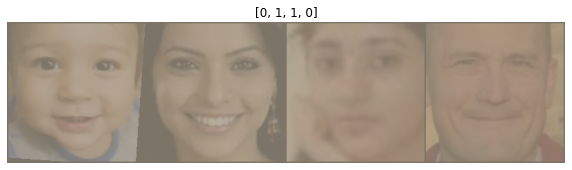

In [57]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    figure(figsize=(10, 15))
    plt.axis('off')
    plt.imshow(inp)
    if title is not None:
        plt.title(title)

inpu = next(iter(dataloaders['train']))
inputs, classes = inpu['image'],inpu['labels']
out = torchvision.utils.make_grid(inputs)
imshow(out, title=classes.tolist())

In [46]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train() 
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            
            for inpu in dataloaders[phase]:
                inputs = inpu['image'].to(device)
                labels = inpu['labels'].to(device)

                
                optimizer.zero_grad()


                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()


                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))


    model.load_state_dict(best_model_wts)
    return model

In [11]:
def predict(model,test_loader):
  predicted = []
  true_labels = []
  model.eval()
  with torch.no_grad():
    for inp in test_loader:
      input = inp['image'].to(device)
      label = inp['labels'].to(device)
      outputs = model(input)
      _, preds = torch.max(outputs,1)
      out = torchvision.utils.make_grid(input)
      predicted += preds.tolist()
      true_labels += label.tolist()
  return predicted ,true_labels

In [12]:
def visualize_model(model, loader,num_images=6):
  was_training = model.training
  model.eval()
  images_so_far = 0
  fig = plt.figure()
  with torch.no_grad():
    for inp in loader:
      inputs = inp['image'].to(device)
      labels = inp['labels'].to(device)
      outputs = model(inputs)
      _, preds = torch.max(outputs, 1)
      figure(figsize=(10, 8))
      plt.axis('off')
      out = torchvision.utils.make_grid(inputs)
      out = out.cpu()
      out = out.numpy().transpose((1, 2, 0))
      plt.imshow(out)
      plt.title(preds.tolist())
      images_so_far += 1
      if images_so_far == num_images:
        return

In [13]:
model_ft = models.resnet101(pretrained=True)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 2)
model_ft = model_ft.to(device)
criterion = nn.CrossEntropyLoss()
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [ ]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,num_epochs=4)

In [ ]:
x,y = predict(model_ft,dataloader_test)

In [ ]:
corrects = 0
for i in range(len(x)):
  corrects += int(x[i] == y[i])
print(corrects/len(x)*100)

91.94432728806412


<Figure size 432x288 with 0 Axes>

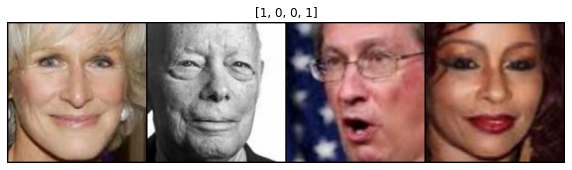

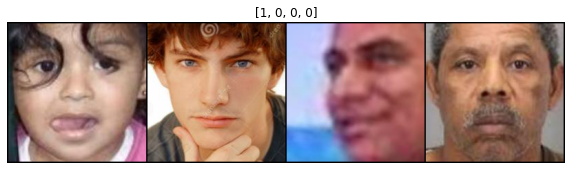

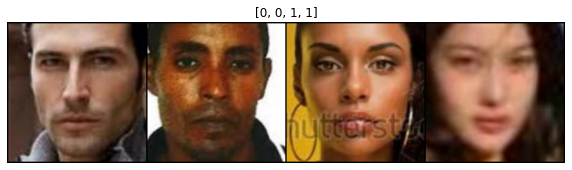

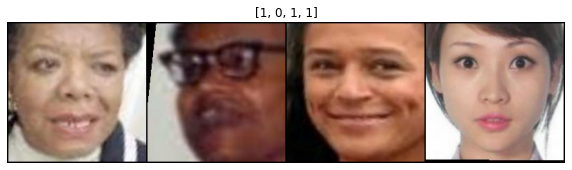

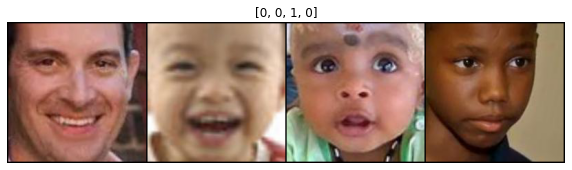

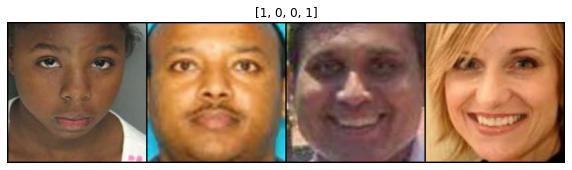

In [ ]:
visualize_model(model_ft,dataloader_test)


**Inference**

In [6]:
!cp "/content/drive/MyDrive/model.pth" "/content/"

In [14]:
model_ft = models.resnet101(pretrained=True)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 2)
model_ft.load_state_dict(torch.load('/content/model.pth'))
model_ft = model_ft.to(device)

In [ ]:
transform = transforms.Compose([
 transforms.ToTensor()
])

transform_normalize = transforms.Normalize(
     mean=[0.485, 0.456, 0.406],
     std=[0.229, 0.224, 0.225]
 )

In [62]:
def grad_cam_visu(image_path,catg):
  target_layer = model_ft.layer4[-1]
  img = Image.open(image_path)
  transformed_img = transform(img)
  input_tensor = transformed_img
  input_tensor = input_tensor.unsqueeze(0)
  cam = GradCAM(model=model_ft, target_layer=target_layer, use_cuda=device)
  target_category = catg
  grayscale_cam = cam(input_tensor=input_tensor, target_category=target_category,aug_smooth=True)
  grayscale_cam = grayscale_cam[0, :]
  visualization = show_cam_on_image(np.array(img)/255, grayscale_cam)
  cv2_imshow(visualization)

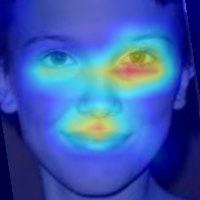

In [63]:
grad_cam_visu("/content/UTKFace/16_1_0_20170116204045849.jpg.chip.jpg",1)

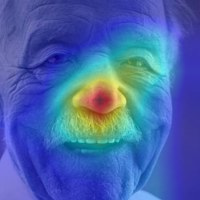

In [64]:
grad_cam_visu("/content/UTKFace/100_0_0_20170112213500903.jpg.chip.jpg",0)

In [24]:
idx_to_labels = {
    '0': 'man',
    '1': 'women'
}

In [65]:
def captum_visua(path_to_img):
  model = model_ft
  model = model.eval()
  img = Image.open(path_to_img)
  transformed_img = transform(img)
  input = transformed_img
  input = input.unsqueeze(0)
  output = model(input.to(device))
  output = F.softmax(output, dim=1)
  prediction_score, pred_label_idx = torch.topk(output, 1)
  pred_label_idx.squeeze_()
  predicted_label = idx_to_labels[str(pred_label_idx.item())]

  print('Predicted:', predicted_label, '(', prediction_score.squeeze().item(), ')')
  
  integrated_gradients = IntegratedGradients(model)
  attributions_ig = integrated_gradients.attribute(input.to(device),n_steps= 60, target=pred_label_idx)
  default_cmap = LinearSegmentedColormap.from_list('custom blue', 
                                                  [(0, '#ffffff'),
                                                    (0.25, '#000000'),
                                                    (1, '#000000')], N=200)
  _ = viz.visualize_image_attr_multiple(np.transpose(attributions_ig.squeeze().cpu().detach().numpy(), (1,2,0)),
                              np.transpose(transformed_img.squeeze().cpu().detach().numpy(), (1,2,0)),
                              methods=["original_image", "heat_map"],
                              signs=['all', 'positive'],
                              cmap=default_cmap,
                              show_colorbar=True)

Predicted: man ( 0.9972100853919983 )


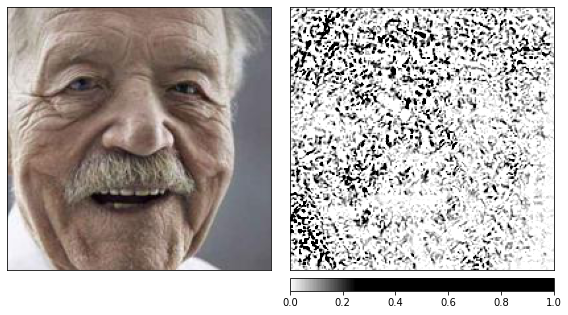

In [66]:
captum_visua('/content/UTKFace/100_0_0_20170112213500903.jpg.chip.jpg')

Predicted: women ( 0.9750851988792419 )


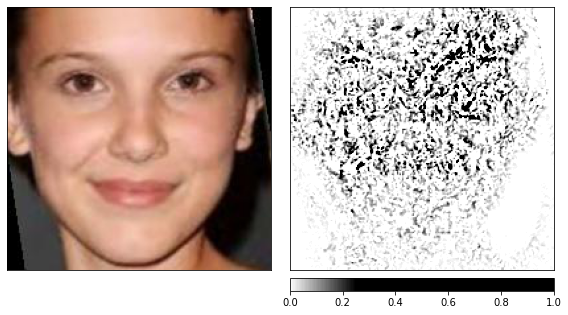

In [67]:
captum_visua('/content/UTKFace/16_1_0_20170116204045849.jpg.chip.jpg')